<a href="https://colab.research.google.com/github/reiuu/honss/blob/one-hot-targets/overfitting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Installs, setup, etc.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Mar  7 18:43:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#assumes we already have tensorflow installed (e.g. on colab)
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi
!pip install muspy #important to have this last, otherwise it interferes with fluidsynth version

In [3]:
import collections
import datetime
import glob
import numpy as np
import pandas as pd
import torchtext
import muspy
import fluidsynth
import tensorflow as tf
import os
import music21
import random
from os import path
from IPython import display
from matplotlib import pyplot as plt

In [4]:
muspy.download_musescore_soundfont()

Start downloading MuseScore General soundfont.
MuseScore General soundfont has successfully been downloaded to : /root/.muspy/musescore-general.


In [20]:
#set a seed so that our model is deterministic (result reproducable)

seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

#constants
NO_FILES = 50
SAMPLING_RATE = 16000
RESOLUTION = 384
BATCH_SIZE = 64
LEARNING_RATE = 0.001
SEQ_LENGTH = 25
VOCAB_SIZE = 355  #356 for event no velocity, 388 for event w/ velocity, 
N_EPOCHS = 250

In [6]:
#download dataset (MAESTRO)
files = []

if not (path.exists('/content/maestro-v3.0.0')):
  url = 'https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip'
  from_path = './maestro-v3.0.0-midi.zip'
  to_path = './'

  torchtext.utils.download_from_url(url, from_path)
  torchtext.utils.extract_archive(from_path, to_path)
else: print('Already downloaded the MAESTRO V3 dataset.')

files = glob.glob('maestro-v3.0.0/*/*.mid*') #create list of all .midi files

100%|██████████| 58.4M/58.4M [00:02<00:00, 20.2MB/s]


In [7]:
files[0]
len(files)
files = random.shuffle(files)

1276

##Datasets

In [8]:
def normalise(music: np.ndarray) -> np.ndarray:
    return music/VOCAB_SIZE
    
def denormalise(music: np.ndarray)-> np.ndarray:
    return music*VOCAB_SIZE

 creating the actual dataset of arrays, from midi files

In [9]:
train_dataset = []
total_notes = 0
validate_dataset = []
test_dataset = []

for file in files[:NO_FILES]:
  midi_file = muspy.read_midi(file)
  train_dataset.append(muspy.to_event_representation(midi_file))
  total_notes += muspy.to_event_representation(midi_file).size
  
for file in files[NO_FILES:NO_FILES + int(NO_FILES*0.1)]: #20% of the train set
  midi_file = muspy.read_midi(file)
  validate_dataset.append(muspy.to_event_representation(midi_file))


defining functions to build the dataset structure

In [10]:
def convert_array(array_ds):
  array_ds = np.concatenate(array_ds).ravel() #turns tuple of numpy arrays into a flat 1d numpy array   
  return array_ds

def create_sequences(array_ds) -> tf.Tensor:
  array_ds = tf.convert_to_tensor(array_ds, dtype=tf.float32)
  array_ds = tf.data.Dataset.from_tensor_slices(array_ds)
  array_ds = array_ds.batch(1)
  array_ds = array_ds.batch(SEQ_LENGTH+1,drop_remainder=True) #+1 because we are removing 1 from array
  #array_ds = tf.reshape(array_ds, (len(array_ds), SEQ_LENGTH, 1))

  return array_ds

def create_target(array_ds):
  test_ds = array_ds[:-1]
  test_ds = normalise(test_ds)

  target = array_ds[-1]
  target = tf.cast(target, tf.int32)
  target = tf.one_hot(target, 356)
  target = tf.squeeze(target)

  return test_ds, target

In [11]:
train_ds = convert_array(train_dataset) #flat array
validate_ds = convert_array(validate_dataset)

In [12]:
train_ds = create_sequences(train_ds) #groups of seq length tensors
dataset = train_ds.map(create_target) #groups of seq length tensors, with 1 target note
dataset = (dataset.shuffle(total_notes+1).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))

In [13]:
validate_ds = create_sequences(validate_ds)
val_dataset = validate_ds.map(create_target)
val_dataset = (val_dataset.shuffle(total_notes+1).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))

In [14]:
for input,target in dataset.take(1):
  print('batch shape:', input.shape)
  print('sequence elements (first 10):', input[4][0: 10]) #check if new target is correct
  print()
  print('taget shape:', target.shape)
  print('target:', target[22])

batch shape: (64, 25, 1)
sequence elements (first 10): tf.Tensor(
[[0.16338028]
 [0.90140843]
 [0.52394366]
 [0.8028169 ]
 [0.15492958]
 [0.943662  ]
 [0.515493  ]
 [0.828169  ]
 [0.23098591]
 [0.7887324 ]], shape=(10, 1), dtype=float32)

taget shape: (64, 356)
target: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [ ]:
#[x for x in dataset]

##Create network and train

In [22]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(
    512,
    input_shape=(SEQ_LENGTH, 1),
    recurrent_dropout=0.3,
    return_sequences=True
))
model.add(tf.keras.layers.LSTM(512))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(VOCAB_SIZE+1))
model.add(tf.keras.layers.Softmax())

loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss=loss, optimizer=optimizer) 

In [23]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [24]:
losses = model.evaluate(dataset)

928/928 [==============================] - 15s 11ms/step - loss: 5.8748


In [26]:
%%time

history = model.fit(
    dataset,
    epochs=20,
    callbacks=callbacks,
    validation_data=val_dataset
)

Epoch 1/20
928/928 [==============================] - 42s 40ms/step - loss: 4.2538 - val_loss: 4.2271
Epoch 2/20
928/928 [==============================] - 41s 40ms/step - loss: 4.1918 - val_loss: 4.1578
Epoch 3/20
928/928 [==============================] - 41s 40ms/step - loss: 4.1402 - val_loss: 4.1365
Epoch 4/20
928/928 [==============================] - 41s 40ms/step - loss: 4.0965 - val_loss: 4.0991
Epoch 5/20
928/928 [==============================] - 41s 40ms/step - loss: 4.0516 - val_loss: 4.0928
Epoch 6/20
928/928 [==============================] - 41s 40ms/step - loss: 4.0142 - val_loss: 4.0850
Epoch 7/20
928/928 [==============================] - 41s 40ms/step - loss: 3.9685 - val_loss: 4.1023
Epoch 8/20
928/928 [==============================] - 41s 40ms/step - loss: 3.9111 - val_loss: 4.1127
Epoch 9/20
928/928 [==============================] - 43s 43ms/step - loss: 3.8494 - val_loss: 4.1382
Epoch 10/20
928/928 [==============================] - 42s 40ms/step - loss: 3.776

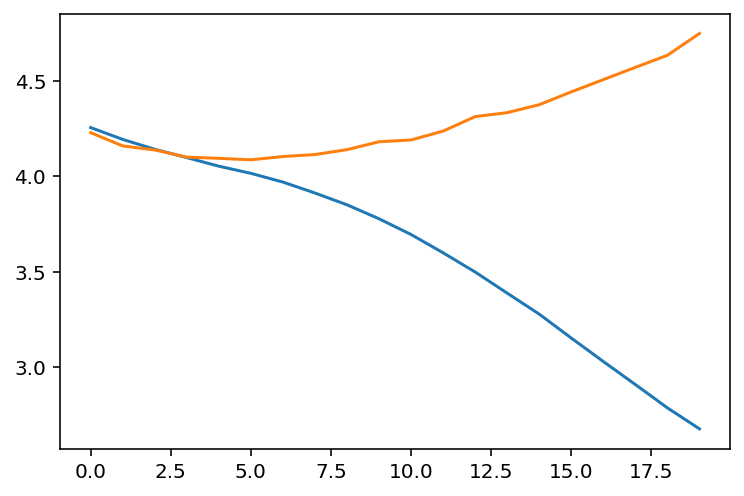

In [27]:
plt.plot(history.epoch, history.history['loss'], history.history['val_loss'], label='total loss')

In [33]:
music = muspy.read_midi(files[0])
music = muspy.to_event_representation(music)
music = music[1:SEQ_LENGTH+2]
music = normalise(music) #XDDDD


#music = normalise(music)
print(music)

[[1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.92676056]
 [0.21126761]
 [0.75492958]
 [0.13521127]
 [0.8056338 ]
 [0.17746479]
 [1.        ]
 [0.87605634]
 [0.53802817]
 [0.81126761]
 [0.49577465]
 [1.        ]
 [0.74084507]
 [0.21690141]
 [0.84507042]
 [0.14084507]
 [0.74084507]
 [0.18309859]]


In [32]:
no_preds = 1
generated = []

def predict(notes, model):
  inputs = tf.expand_dims(notes, 0)
  predictions = model.predict(inputs)
  
  notes = np.squeeze(predictions)
  
  #notes = notes*VOCAB_SIZE
  print(notes)
  #notes = tf.random.categorical(notes, num_samples=1)

  #notes = np.around(notes)
  #notes = notes.astype(int)
  #print(notes)
  note = np.argmax(notes)
  print(note)
  return note

#print()

for i in range (no_preds):                         #complete this function: append bugged with dimension or similar?
  note = predict(music, model)
  #generated.append(note)
  #music = np.append(music, note)
  #music = music[1:]

#generated = np.asarray(generated)
#generated = append_note_off(generated)

#muspy.show_pianoroll(muspyfile)

[6.84447166e-10 8.46126225e-10 7.63719199e-10 1.16096865e-09
 8.78080220e-10 8.11693490e-10 1.03116782e-09 8.07521050e-10
 7.30176142e-10 1.19158505e-09 9.39422984e-10 1.39464063e-09
 7.07894687e-10 1.21626709e-09 9.05530206e-10 1.05576836e-09
 9.49565204e-10 8.28568270e-10 8.19832480e-10 8.50605253e-10
 1.21431531e-09 7.26018357e-10 1.26015232e-09 1.43178769e-09
 5.96801983e-05 1.22908830e-06 2.44693439e-08 1.91702507e-04
 1.01613245e-04 5.50694458e-05 2.30466598e-04 6.45909386e-05
 2.83752361e-05 4.89992881e-03 3.40854982e-04 1.05507765e-03
 6.82904967e-04 1.97572983e-04 1.21280178e-03 6.69589685e-03
 5.97103732e-04 3.85937747e-03 1.17917629e-02 3.04943253e-03
 6.55402848e-03 4.59204195e-03 3.18662859e-02 7.69352191e-04
 1.37836789e-03 5.43020898e-03 1.26767484e-02 3.76296812e-03
 5.52335987e-03 3.72326225e-02 4.58714645e-03 1.79590788e-02
 2.85875071e-02 2.59133913e-02 1.20129008e-02 1.16207749e-02
 4.45117243e-02 2.68422458e-02 1.30476495e-02 4.06824313e-02
 2.11904813e-02 2.801550